# Train the neural network

## Get data

In [1]:
%matplotlib inline
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
import matplotlib.pyplot as plt
from time import time

In [2]:
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
('X shape: ', X.shape, 'X dtype', X.dtype, 'y:', y)

('X shape: ', (28, 28, 1), 'X dtype', numpy.uint8, 'y:', 2)

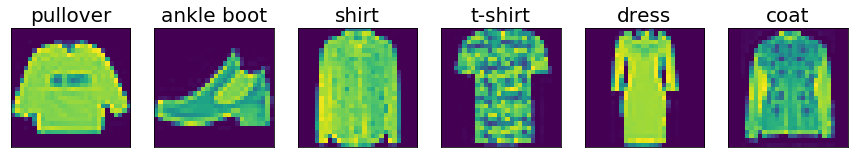

In [3]:
text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]

X, y = mnist_train[0:6]

_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))

for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

mnist_train = mnist_train.transform_first(transformer)

In [5]:
batch_size = 256

train_data = gluon.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)

In [6]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


In [7]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size, num_workers=4)

## Define the Model

In [8]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))
net.initialize(init=init.Xavier())

In [9]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [10]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## Train

In [11]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) == label.astype('float32')).mean().asscalar()

In [12]:
for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)

    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(net(data), label)

    print("Epoch %d: Loss: %.3f, Train acc %.3f, Test acc %.3f, Time %.1f sec" % 
          (
            epoch, 
            train_loss / len(train_data),
            train_acc / len(train_data),
            valid_acc / len(valid_data),
            time() - tic
          )
    )

Epoch 0: Loss: 0.841, Train acc 0.686, Test acc 0.815, Time 40.3 sec
Epoch 1: Loss: 0.474, Train acc 0.825, Test acc 0.852, Time 50.7 sec
Epoch 2: Loss: 0.404, Train acc 0.851, Test acc 0.868, Time 43.8 sec
Epoch 3: Loss: 0.364, Train acc 0.867, Test acc 0.880, Time 34.9 sec
Epoch 4: Loss: 0.342, Train acc 0.874, Test acc 0.886, Time 33.9 sec
Epoch 5: Loss: 0.321, Train acc 0.881, Test acc 0.889, Time 35.5 sec
Epoch 6: Loss: 0.304, Train acc 0.888, Test acc 0.883, Time 39.3 sec
Epoch 7: Loss: 0.291, Train acc 0.892, Test acc 0.894, Time 46.5 sec
Epoch 8: Loss: 0.284, Train acc 0.895, Test acc 0.895, Time 36.3 sec
Epoch 9: Loss: 0.273, Train acc 0.898, Test acc 0.894, Time 37.7 sec


# Save model

In [13]:
net.save_parameters('net.params')

# Predict by trained model

## Prerequisites

In [14]:
from mxnet import nd
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
import matplotlib.pyplot as plt

In [15]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))

In [16]:
net.load_parameters('net.params')

## Predict

In [17]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

In [18]:
mnist_valid = datasets.FashionMNIST(train=False)
X, y = mnist_valid[:6]
preds = []
for x in X:
    x = transformer(x).expand_dims(axis=0)
    pred = net(x).argmax(axis=1)
    preds.append(pred.astype('int32').asscalar())

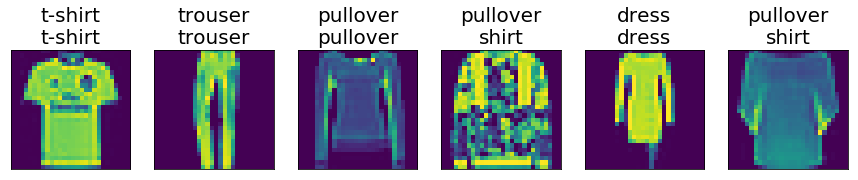

In [19]:
_, figs = plt.subplots(1, 6, figsize=(15, 15))
text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]
for f,x,yi,pyi in zip(figs, X, y, preds):
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[yi]+'\n'+text_labels[pyi])
    ax.title.set_fontsize(20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Predict with models from Gluon model zoo

In [20]:
from mxnet.gluon.model_zoo import vision as models
from mxnet.gluon.utils import download
from mxnet import image

net = models.resnet50_v2(pretrained=True)

Model file is not found. Downloading.


In [21]:
url = 'http://data.mxnet.io/models/imagenet/synset.txt'
fname = download(url)
with open(fname, 'r') as f:
    text_labels = [' '.join(l.split()[1:]) for l in f]

In [22]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/\
Golden_Retriever_medium-to-light-coat.jpg/\
365px-Golden_Retriever_medium-to-light-coat.jpg'
fname = download(url)
x = image.imread(fname)

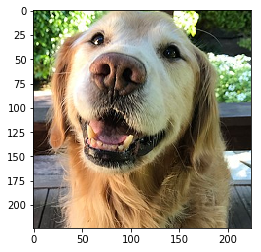

In [23]:
x = image.resize_short(x, 256)
x, _ = image.center_crop(x, (224,224))
plt.imshow(x.asnumpy())
plt.show()

In [24]:
def transform(data):
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    rgb_mean = nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
    rgb_std = nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std

In [25]:
prob = net(transform(x)).softmax()
idx = prob.topk(k=5)[0]
for i in idx:
    i = int(i.asscalar())
    print('With prob = %.5f, it contains %s' % (
        prob[0,i].asscalar(), text_labels[i]))

With prob = 0.98631, it contains golden retriever
With prob = 0.00478, it contains Irish setter, red setter
With prob = 0.00328, it contains Labrador retriever
With prob = 0.00165, it contains English setter
With prob = 0.00120, it contains Brittany spaniel
